## Loading Model and Processor

In [ ]:
from transformers import SpeechT5ForTextToSpeech
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00


# Loading Dataset

In [ ]:
from datasets import load_dataset, Audio

dataset = load_dataset("csv", data_files = "/content/drive/MyDrive/Colab Notebooks/TTS/ALL_DATASET/metadata_COLAB.csv", split = "train")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
# Print a sample from the dataset
print(dataset[0])

Generating train split: 0 examples [00:00, ? examples/s]

{'text': 'bst stands for binary search tree', 'audio': {'path': '/content/drive/MyDrive/Colab Notebooks/TTS/ALL_DATASET/data/Processed_DATASET/data/processed_full_forms/full_forms-01.wav', 'array': array([0.00283813, 0.00265503, 0.00292969, ..., 0.00204468, 0.        ,
       0.        ]), 'sampling_rate': 16000}}


In [ ]:
dataset.features

{'text': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None)}

## Data Preprocessing

In [ ]:
tokenizer = processor.tokenizer

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/11247 [00:00<?, ? examples/s]

In [ ]:
dataset_vocab - tokenizer_vocab

{' ',
 '$',
 '%',
 '&',
 '*',
 '+',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '@',
 '_',
 '\xa0',
 '’',
 '“',
 '”'}

In [ ]:
import re
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation (except apostrophes)
    text = re.sub(r'[^\w\s\']', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Define a function to add the normalized_text column
def add_normalized_text(example):
    example['text'] = normalize_text(example['text'])
    return example

# Apply the function to the dataset
dataset = dataset.map(add_normalized_text)

Map:   0%|          | 0/11247 [00:00<?, ? examples/s]

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/11247 [00:00<?, ? examples/s]

In [ ]:
dataset_vocab - tokenizer_vocab

{' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_'}

In [ ]:
replacements = [
    ("0", "zero"),
    ("1", "one"),
    ("2", "two"),
    ("3", "three"),
    ("4", "four"),
    ("5", "five"),
    ("6", "six"),
    ("7", "seven"),
    ("8", "eight"),
    ("9", "nine"),
    ("_", " "),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["text"] = inputs["text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/11247 [00:00<?, ? examples/s]

In [ ]:
len(dataset)

11247

## Creating Speaker Embeddings

In [ ]:
!pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.2/807.2 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 53.1 MB/s eta 0:00:00


In [ ]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("spek_embd", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

<ipython-input-20-4c34ad311fc6>:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [ ]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(text=example["text"],audio_target=audio["array"],sampling_rate=audio["sampling_rate"],return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [ ]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

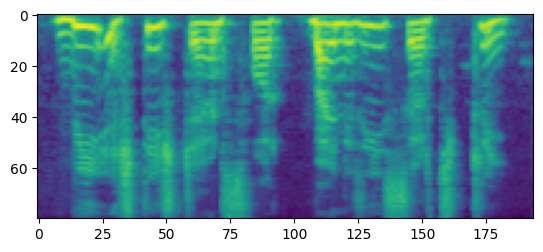

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [ ]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/11247 [00:00<?, ? examples/s]

## Removing Too long Sentences

In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/11247 [00:00<?, ? examples/s]

11219

## Model Finetuning 

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 10097
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 1122
    })
})

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="English_Technical_finetuned",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=0.0001,
    warmup_steps=100,
    max_steps=1000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    save_total_limit=3,  # Keep only 3 checkpoints to save space
    per_device_eval_batch_size=2,
    save_steps=100,
    eval_steps=100,
    logging_steps=50,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
100,0.612200,0.528936
200,0.546800,0.488451
300,0.520700,0.474538
400,0.508600,0.472899
500,0.501200,0.463771
600,0.498200,0.456426
700,0.488800,0.452811
800,0.486200,0.451452
900,0.486600,0.445400
1000,0.475300,0.445107


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/e

TrainOutput(global_step=1000, training_loss=0.5227841968536378, metrics={'train_runtime': 2532.9263, 'train_samples_per_second': 12.634, 'train_steps_per_second': 0.395, 'total_flos': 2706282114619248.0, 'train_loss': 0.5227841968536378, 'epoch': 3.1683168316831685})

In [ ]:
trainer.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


CommitInfo(commit_url='https://huggingface.co/Tejasva-Maurya/English_Technical_finetuned/commit/2130aa8b8426908d51207b32df931be4328ca813', commit_message='End of training', commit_description='', oid='2130aa8b8426908d51207b32df931be4328ca813', pr_url=None, pr_revision=None, pr_num=None)

## Model Inference

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
from datasets import load_dataset
import torch
import soundfile as sf
from IPython.display import Audio

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("Tejasva-Maurya/English_Technical_finetuned")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

example = dataset["test"][0]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)


In [ ]:
text = "gpu stands for graphics processing unit"
inputs = processor(text=text, return_tensors="pt")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

sf.write("speech_3_finetuned.wav", speech.numpy(), samplerate=16000)
Audio(speech.numpy(), rate=16000)
